# Odometer display

Display a float as a mechanical odometer readout.

Notes:

* Intended for smooth animation but also for accurate readout of point values
* Propagates rotational offsets to higher dials via a transfer function as lower dial rotates from ~9 back to 0 
* Uses matplotlib to render an intermediate array of display digits and rotational offsets
* Many parameters (defined as constants), but not extensively tested. Should be configurable but no guarantees


Utility methods

In [1]:
import numpy as np

BASE = 10
DIGITS = np.roll(np.arange(BASE), 1)
WINDOW = 3

def display_window(target):
  return np.roll(DIGITS, -target)[:WINDOW]

def ease_quart(x):
  def ease_in(x):  return 8 * np.power(x, 4)
  def ease_out(x): return 1 - np.power(-2 * x + 2, 4) / 2
  return np.piecewise(x, [x < 0.5, x >= 0.5], [ease_in, ease_out])

def transfer(x, start=0.85):
  return np.piecewise(x,
                      [x < start, x >= start],
                      [0, lambda x: ease_quart((x - start) / (1 - start))])

Return arrays of display digits and rotational offsets

In [2]:
OFFSET_FACTOR = 0.5

def odometer_values(x, max_wheel, min_wheel):
  offset = 0
  dws = np.zeros((max_wheel - min_wheel, WINDOW), dtype=int)
  offs = np.zeros(max_wheel - min_wheel)
  for i in range(min_wheel, max_wheel):
    # calculate nominal display digits and rotation offset
    place = pow(BASE, i)
    value = (x % place) / place
    rotation = value * BASE
    digit = int(rotation)
    adjust = OFFSET_FACTOR * offset
    remainder = (int(BASE * (rotation % 1)) + adjust) / BASE
    offset = remainder if i == min_wheel else transfer(remainder)
    # assign digits and offset
    dws[i - min_wheel,:] = display_window(digit)
    offs[i - min_wheel] = offset
  return dws, offs

Parameters for render

In [3]:
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.style.use('dark_background')

WHEELS = 6
BG_STEPS = 20
DIGIT_HEIGHT = 3 * BG_STEPS / 2
DIGIT_BASELINE = BG_STEPS / 4
DIGIT_SPACING = DIGIT_HEIGHT / 2
BG_SHADE_RANGE = 0.125
BG_Y = np.linspace(-1, 1, BG_STEPS, endpoint=True)
BG_V = np.cos(2 * math.pi * BG_SHADE_RANGE * BG_Y)
BG_M = np.stack([BG_V] * WHEELS).T
DIGIT_H_SHIFT = -1.2
LINE_H_SHIFT = 0.7

Render into matplotlib axes

In [4]:
def plot_odometer(ax, values):
  ax.imshow(BG_M, origin='lower', aspect=(1.0 / BG_STEPS), cmap="Greys", vmin=0, vmax=1)
  ax.axis('off')
  dws = values[0]
  offs = values[1]
  for i in range(dws.shape[0]):
    hpos = dws.shape[0] + DIGIT_H_SHIFT - i
    vpos = DIGIT_BASELINE + DIGIT_SPACING * offs[i]
    ax.text(hpos, vpos + DIGIT_SPACING, dws[i, 0], fontsize=DIGIT_HEIGHT, clip_on=True)
    ax.text(hpos, vpos, dws[i, 1], fontsize=DIGIT_HEIGHT, clip_on=True)
    ax.text(hpos, vpos - DIGIT_SPACING, dws[i, 2], fontsize=DIGIT_HEIGHT, clip_on=True)
    if i > 0:
      lpos = hpos + LINE_H_SHIFT
      ax.plot([lpos, lpos], [0, BG_STEPS - 1], color='black')

Render a value

In [5]:
def odometer(ax, x, max_wheel=(WHEELS + 1), min_wheel=1):
  return plot_odometer(ax, odometer_values(x, max_wheel, min_wheel))

Odometer for 1998.5



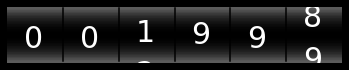

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
odo_val = 1998.5
odometer(ax, odo_val)
print(f"Odometer for {odo_val}\n")
plt.show()